## 1. Set up the experiment


Zero-shot superresolution: From `(32, 32)` to `(64, 64)`.

### 1-1. Import modules

In [1]:
import  os, sys, time
from    pathlib             import  Path
import  pickle
import  yaml

import  numpy       as  np
import  torch
from    torch.utils.data            import  TensorDataset, DataLoader

from    matplotlib.axes     import  Axes
import  matplotlib.pyplot   as      plt

path_script = Path(os.getcwd())
path_work   = path_script.parent.parent
sys.path.append(str(path_work))

from    deep_numerical.utils     import  GaussianNormalizer
from    deep_numerical.utils     import  count_parameters
from    deep_numerical.utils     import  relative_error
from    deep_numerical.utils     import  ones, repeat, velocity_grid
from    deep_numerical.neuralop  import  ModifiedRFNO
from    deep_numerical.numerical import  distribution   as  dist

from    train_utils.train_utils  import  load_data

### 1-2. Load the configurations

In [2]:
train_prefix = "20250625_182259"
with open(str( path_script / train_prefix / "config_train.yaml" )) as f:
    config      = yaml.load(f, Loader = yaml.FullLoader)
    _exp        = config['experiment']
    _model      = config['rfno']
    _data       = config['pde_dataset']
DIMENSION = len(_model['n_modes'])

### 1-3. Set the experiment

In [3]:
# key: experiment
RANDOM_SEED:    int = _exp['seed']
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
print(f"Random seed: {RANDOM_SEED}")

BATCH_SIZE:     int             = _exp['batch_size']
TEST_SIZE:      int             = None
DEVICE:         torch.device    = torch.device(f"cuda:3")

# key: train_info
TRAIN_RESOLUTION:   int = _data['resolution']
def get_path(model_appendix: str='') -> str:
    return f"{train_prefix}/rfno{model_appendix}_boltzmann{TRAIN_RESOLUTION}_res{TRAIN_RESOLUTION}"

# key: pde_dataset
TEST_PATH:      Path    = Path(_data['path_test'])

NUM_TIME_STEPS = _data['num_time_steps']
VHS_COEFF = 0.0

Random seed: 123


In [4]:
model = ModifiedRFNO(**_model)
model.load_state_dict(torch.load(get_path()+".pth", weights_only=True))
model.to(DEVICE)
print(f"The number of the parameters\n>>> {count_parameters(model)}")

The number of the parameters
>>> 1102881


### 1-4. Report the train history

Minimum training relative error (data, cons) >>> 8.4948e-04, 1.2857e-04
Minimum validation relative error (data, cons) >>> 1.0992e-03, 4.3894e-04
Training time: 1632.09 second(s).


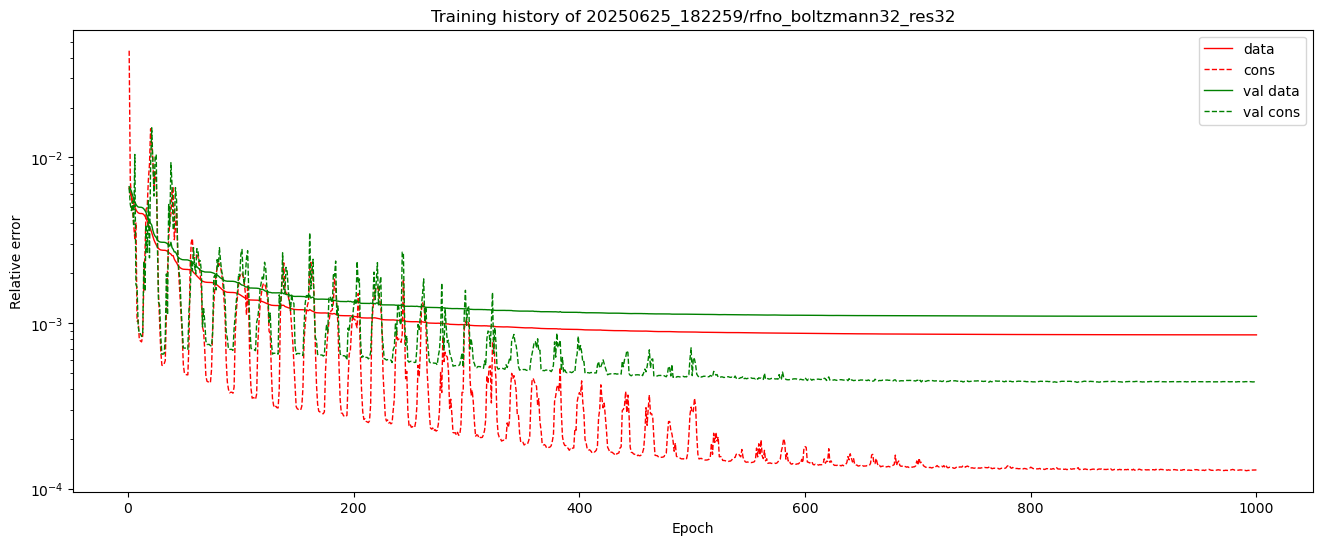

In [5]:
train_rel_error__data:  list[float] = []
train_rel_error__cons:  list[float] = []
val_rel_error__data:    list[float] = []
val_rel_error__cons:    list[float] = []
train_time:         float       = 0.0

# Train history
with open(f"{get_path()}.pickle", "rb") as f:
    custom_train_history = pickle.load(f)
    train_rel_error__data:  torch.Tensor = \
        torch.tensor(custom_train_history['train_rel_error'], dtype = torch.float)
    train_rel_error__cons:  torch.Tensor = \
        torch.tensor(custom_train_history['train_rel_error_cons'], dtype = torch.float)
    val_rel_error__data:    torch.Tensor = \
        torch.tensor(custom_train_history['val_rel_error'], dtype = torch.float)
    val_rel_error__cons:    torch.Tensor = \
        torch.tensor(custom_train_history['val_rel_error_cons'], dtype = torch.float)
    train_time:         float = \
        custom_train_history['train_time']

# Number of epochs
NUM_TRAIN_EPOCHS = train_rel_error__data.numel()
_epoch_list = torch.arange(NUM_TRAIN_EPOCHS) + 1

# Print training data
print(
    "Minimum training relative error (data, cons) >>>",
    f"{train_rel_error__data.min().item():.4e}, {train_rel_error__cons.min().item():.4e}",
)
print(
    "Minimum validation relative error (data, cons) >>>",
    f"{val_rel_error__data.min().item():.4e}, {val_rel_error__cons.min().item():.4e}",
)
print(f"Training time: {train_time:.2f} second(s).")


# Plot
fig, axes = plt.subplots(1, 1, figsize=(16, 6))
axes.set_title("Relative error")
### Train data
axes.plot(
    _epoch_list, train_rel_error__data,
    c='r', linewidth=1, linestyle='-',
    label='data'
)
axes.plot(
    _epoch_list, train_rel_error__cons,
    c='r', linewidth=1, linestyle='--',
    label='cons'
)
### Validation data
axes.plot(
    _epoch_list, val_rel_error__data,
    c='g', linewidth=1, linestyle='-',
    label='val data'
)
axes.plot(
    _epoch_list, val_rel_error__cons,
    c='g', linewidth=1, linestyle='--',
    label='val cons'
)
axes.set_xlabel("Epoch")
axes.set_ylabel("Relative error")
axes.set_yscale("log")
axes.legend()
axes.set_title(f"Training history of {get_path()}")
plt.show()

## 2. Preprocess data

### 2-1. Instantiate the storages

In [6]:
k_in    = 'data'
test_data:  dict[str, torch.Tensor]= {
    k_in:       None,
}

### 2-2. Load the normalizers and the test dataset

In [7]:
# Normalizers
normalizer: dict[str, GaussianNormalizer] = {k_in: None}
_normalizer = torch.load(f"{get_path()}_normalizer.pth", weights_only=False)
for k in normalizer.keys():
    normalizer[k] = _normalizer[k]
    normalizer[k].to(DEVICE)

In [8]:
# Test data
test_data, test_info = load_data(TEST_PATH, 64, VHS_COEFF, [2])
V_MAX           = test_info['v_max']
WHERE_CLOSED    = test_info['v_where_closed']
test_data['data'] = test_data['data'][:, :NUM_TIME_STEPS].to(DEVICE)

for k in normalizer.keys():
    test_data[k] = normalizer[k].encode(test_data[k])

TEST_SIZE   = test_data[k_in].shape[0]
RESOLUTION        = test_data[k_in].shape[-2]

print(f"The size of the test dataset >>>", TEST_SIZE, sep=' ')
print(f"The shape of the test dataset >>>", test_data[k_in].shape, sep=' ')
print('-'*50)
print(f"The number of time steps >>>", NUM_TIME_STEPS, sep=' ')

The size of the test dataset >>> 20
The shape of the test dataset >>> torch.Size([20, 51, 64, 64, 1])
--------------------------------------------------
The number of time steps >>> 51


### 2-3. Instantiate dataloaders

In [9]:
test_dataset = TensorDataset(test_data[k_in])
"""The `TensorDataset` class, which saves the *normalized* dataset."""

test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
"""The `DataLoader` class, which loads the *normalized* dataset (`test_dataset`)."""

'The `DataLoader` class, which loads the *normalized* dataset (`test_dataset`).'

## 3. Test the model

### 3-1. Test the model

In [10]:
# Save the initial conditions
pred_list      = [
    normalizer[k_in].decode(test_data[k_in][:, 0]).cpu()
]
"""Saves *decoded* predictions."""
traj_list = [
    normalizer[k_in].decode(test_data[k_in][:, 0]).cpu()
]
"""Saves *decoded* target data."""
test_rel_error_list = [
    relative_error(pred_list[0], traj_list[0]).cpu()
]
"""Saves the relative errors between the *decoded* predictions and targets."""

for k in normalizer.keys():
    normalizer[k].to(DEVICE)

# Test the model
model.eval()
elapsed_time = time.time()
with torch.no_grad():
    val_rel_error:  float   = 0
    with torch.no_grad():
        for traj, in test_loader:
            traj:   torch.Tensor  = traj.to(DEVICE)
            num_trajectories    = len(traj)
            pred = traj[:, 0]
            
            for idx in range(NUM_TIME_STEPS - 1):
                # Time-marching (in the scaled space)
                pred = model.forward(pred)
                # Descale data
                pred_decoded    = normalizer[k_in].decode(pred)
                target_decoded  = normalizer[k_in].decode(traj[:, idx+1])
                # Loss 1 - Data-driven loss
                _test_rel_error = relative_error(pred_decoded, target_decoded, p=2.0)
                # Backup
                pred_list.append(pred_decoded.cpu())
                traj_list.append(target_decoded.cpu())
                test_rel_error_list.append(_test_rel_error.cpu())
elapsed_time = time.time() - elapsed_time
traj_list           = torch.stack(traj_list, dim=1)
pred_list           = torch.stack(pred_list, dim=1)
test_rel_error_list = torch.stack(test_rel_error_list, dim=-1)

In [11]:
max_rel_error = relative_error(pred_list, traj_list)
idx_evaluation = 50
assert max_rel_error.ndim==1
b_best = torch.argmin(test_rel_error_list[:, idx_evaluation])
b = torch.argmax(test_rel_error_list[:, idx_evaluation])

print(f"* Elapsed time: {elapsed_time:.2f} second(s)")
print(f"* Relative error (p=2):")
print(f"  - Average: {test_rel_error_list[:, idx_evaluation].mean():.4e}")
print(f"  - std.dev: {test_rel_error_list[:, idx_evaluation].std():.4e}")
print(f"  - Best case:  {test_rel_error_list[b_best, idx_evaluation]:.4e} (at instance {b_best})")
print(f"  - Worst case: {test_rel_error_list[b, idx_evaluation]:.4e} (at instance {b})")

* Elapsed time: 0.44 second(s)
* Relative error (p=2):
  - Average: 2.4833e-02
  - std.dev: 1.5570e-02
  - Best case:  1.0182e-02 (at instance 5)
  - Worst case: 6.6307e-02 (at instance 7)


## 4. Plot some predictions

In [12]:
random_t_idx = [0, 10, 20, 30, 40, 50]

newshape = (
    TEST_SIZE, NUM_TIME_STEPS,
    *ones(DIMENSION), *repeat(RESOLUTION, DIMENSION),
    1
)
v_grid = velocity_grid(DIMENSION, RESOLUTION, V_MAX)

extent_v = (-V_MAX, V_MAX, V_MAX, -V_MAX)

In [13]:
init_list = pred_list[:, 0].reshape((TEST_SIZE, *ones(DIMENSION), *repeat(RESOLUTION, DIMENSION), 1))
initial_moments = dist.compute_moments_homogeneous(init_list, v_grid)
equi_list = dist.maxwellian_homogeneous(v_grid, *initial_moments)
deviance = relative_error(init_list, equi_list).flatten()

b_most_deviated = torch.argmax(deviance)
print(f"Most deviated initial condition: Instance {b_most_deviated}")

Most deviated initial condition: Instance 7


### 4-1. The worst prediction

The shape of a trajectory: torch.Size([51, 1, 1, 64, 64, 1])


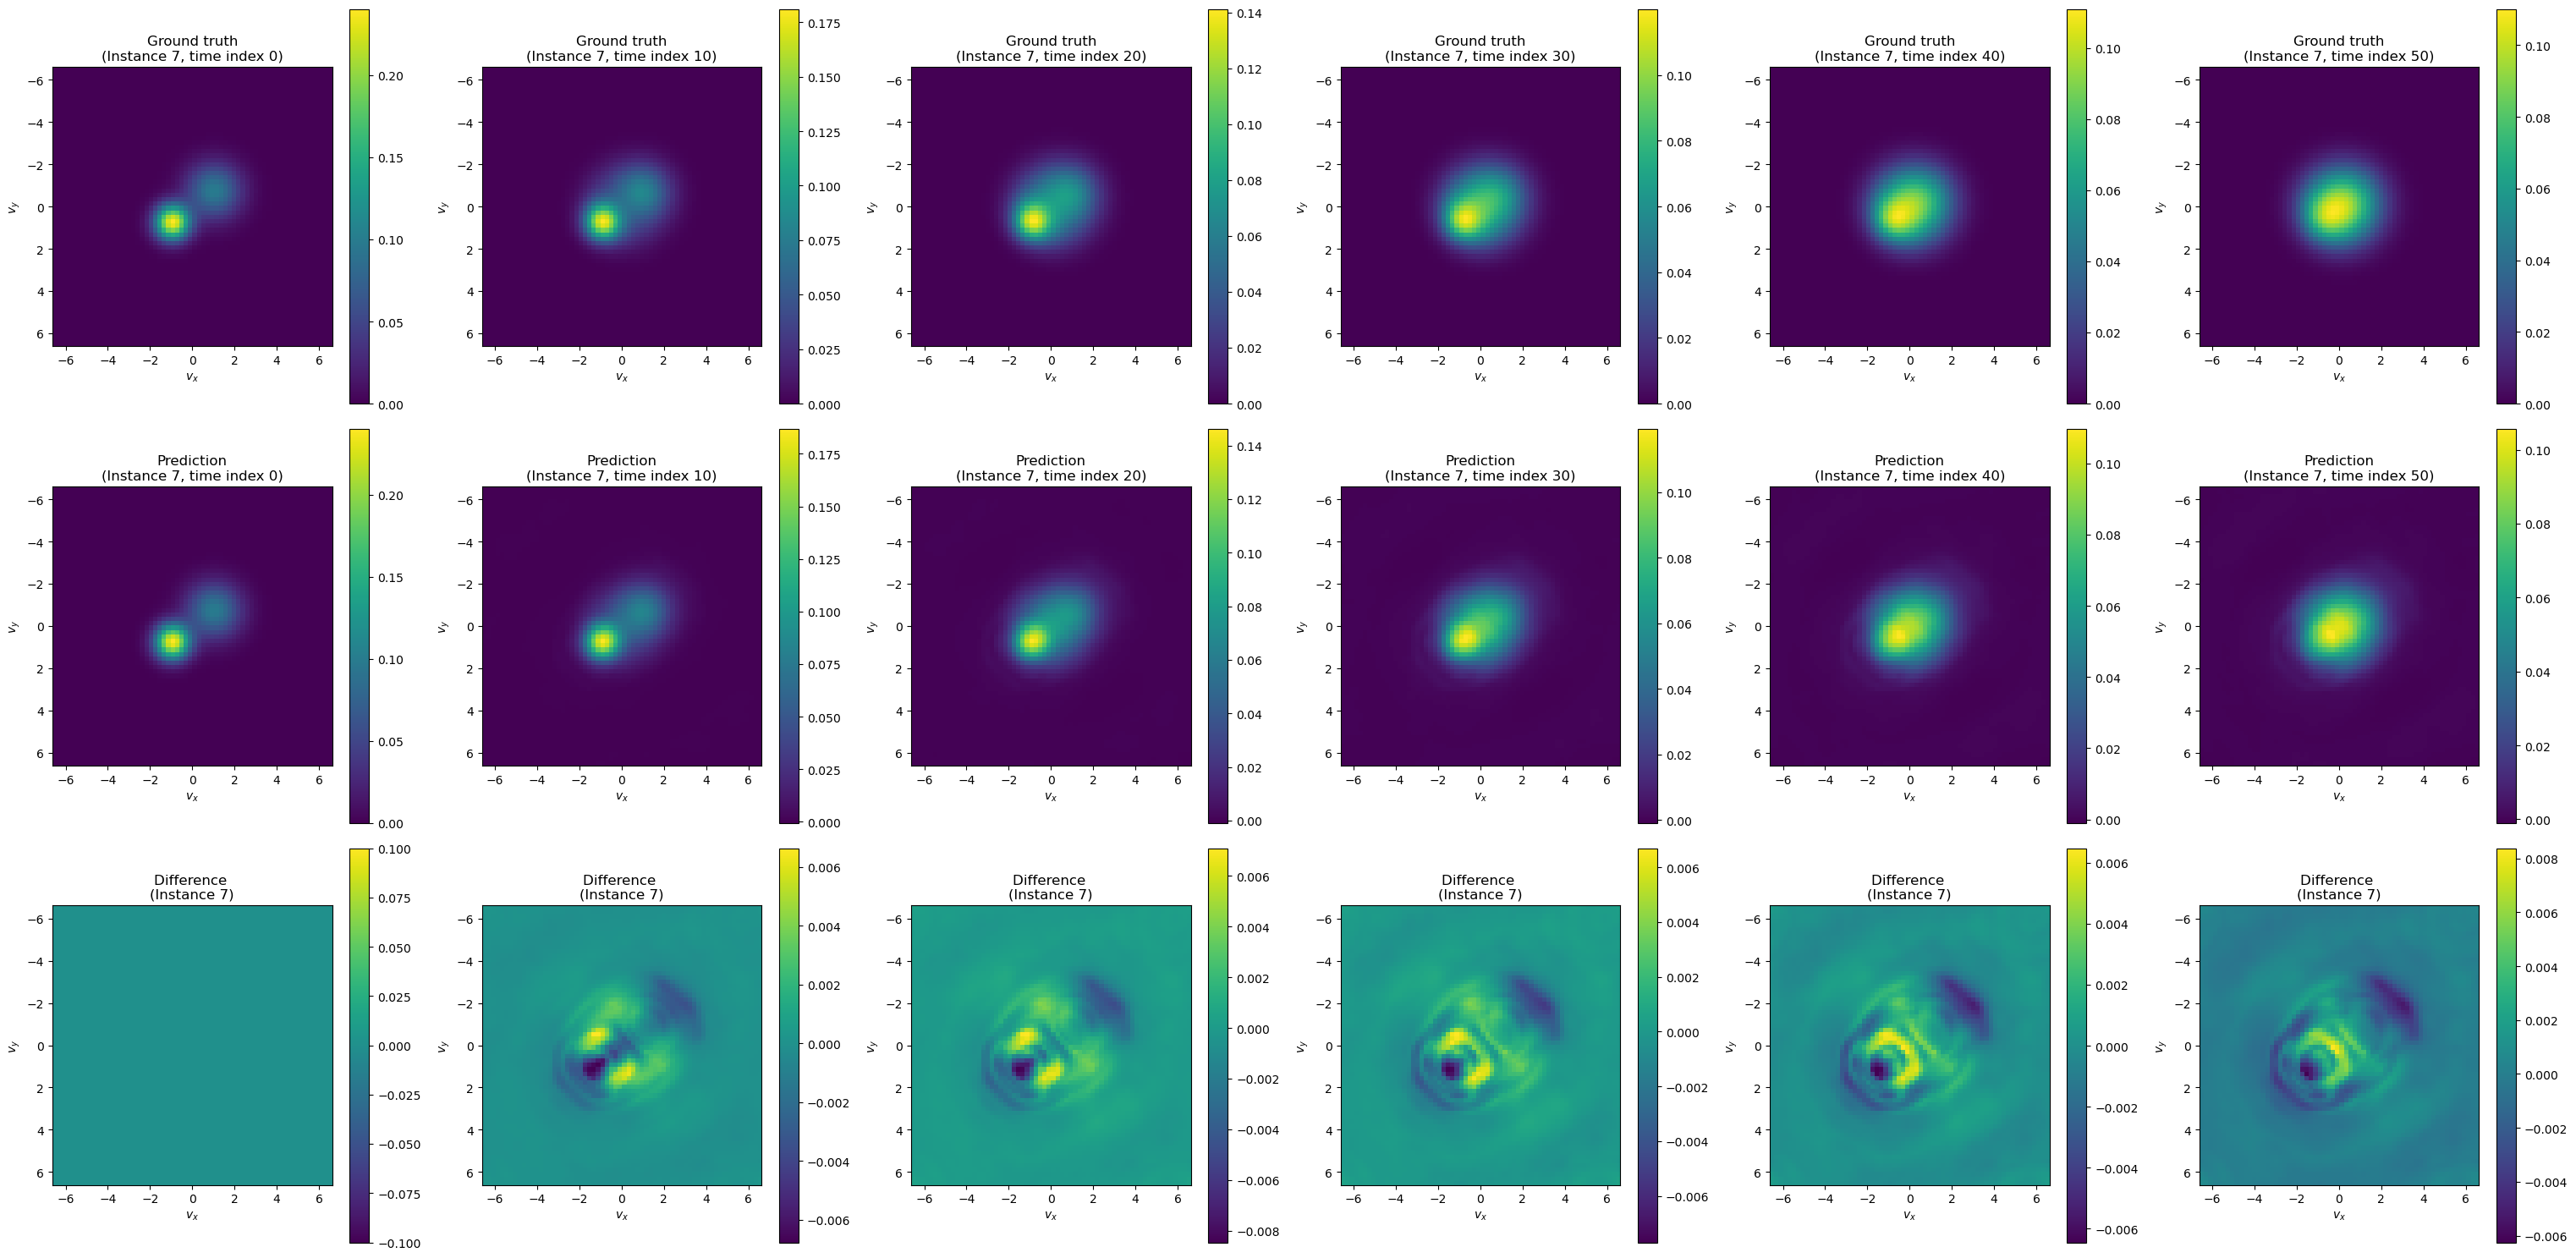

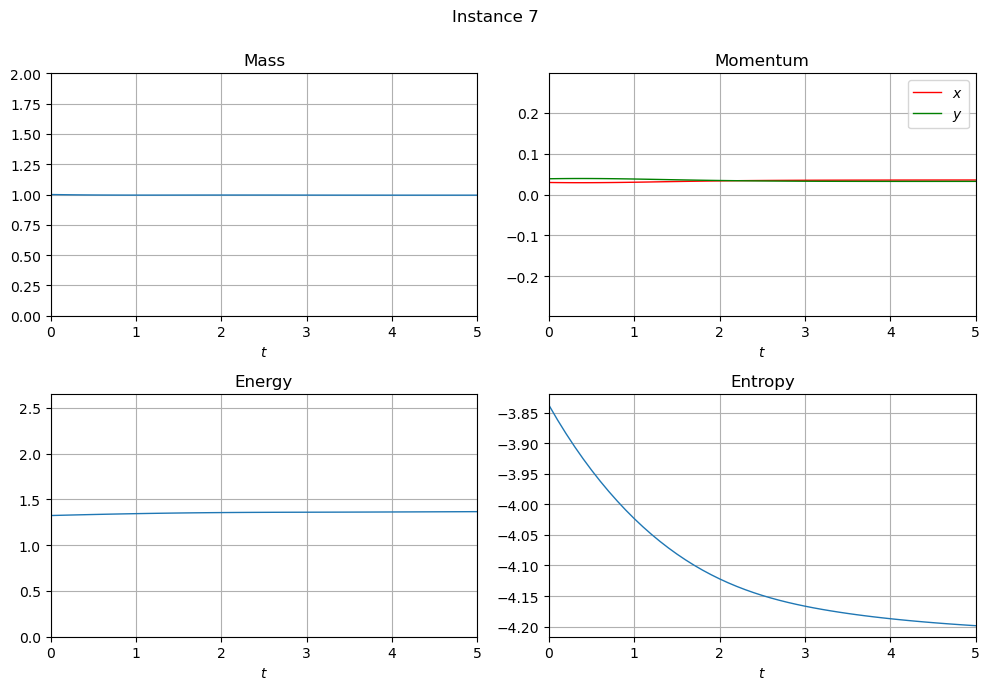

In [14]:
_side_length = 5.0
fig, axes = plt.subplots(3, len(random_t_idx), figsize=(len(random_t_idx)*(_side_length+0.1), 3*_side_length))

batch_idx = b_most_deviated

for cnt, idx in enumerate(random_t_idx):
    axes[0, cnt].set_title(f"Ground truth\n(Instance {batch_idx}, time index {idx})")
    axes[1, cnt].set_title(f"Prediction\n(Instance {batch_idx}, time index {idx})")
    axes[2, cnt].set_title(f"Difference \n(Instance {batch_idx})")
    _t = traj_list[batch_idx, idx].reshape((RESOLUTION, RESOLUTION))
    _p = pred_list[batch_idx, idx].reshape((RESOLUTION, RESOLUTION))
    fig.colorbar(axes[0, cnt].imshow(_t, extent=extent_v))
    fig.colorbar(axes[1, cnt].imshow(_p, extent=extent_v))
    fig.colorbar(axes[2, cnt].imshow((_t-_p), extent=extent_v))
    axes[0, cnt].set_xlabel(r"$v_x$")
    axes[0, cnt].set_ylabel(r"$v_y$")
    axes[1, cnt].set_xlabel(r"$v_x$")
    axes[1, cnt].set_ylabel(r"$v_y$")
    axes[2, cnt].set_xlabel(r"$v_x$")
    axes[2, cnt].set_ylabel(r"$v_y$")
fig.tight_layout()
fig.show()

__pred_list = pred_list.reshape(newshape)
__one_pred  = __pred_list[b_most_deviated]

print(f"The shape of a trajectory: {__one_pred.shape}")
fig, axes = dist.plot_quantities_homogeneous(
    __one_pred,
    v_grid,
    arr_t = 0.1*torch.arange(NUM_TIME_STEPS),
    dim=2,
    mode='plot',
    scatter_size=10,
)
fig.suptitle(f"Instance {b_most_deviated}")
fig.show()

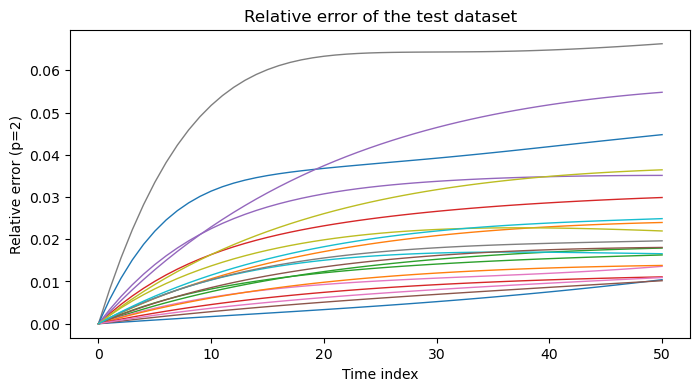

In [15]:
plt.figure(figsize=(8,4))
plt.title("Relative error of the test dataset")
plt.xlabel("Time index")
plt.ylabel("Relative error (p=2)")
plt.plot(test_rel_error_list.T.cpu(), linewidth=1, linestyle='-')
# plt.scatter(25*torch.ones(deviance.shape), deviance, s=10, c='g')
plt.show()

## End of file